In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

from scipy.stats import skew, kurtosis

import pygris
from shapely.geometry import Polygon

import shapely

In [2]:
states = pygris.states()

Using the default year of 2021


In [3]:
state_df = states[['STUSPS', 'NAME', 'geometry']]

In [4]:
# Extracting bounds of each geometry
# bounds = state_df.geometry.bounds

In [5]:
state_df.head()

,STUSPS,NAME,geometry
0,WY,Wyoming,"POLYGON ((-111.05456 45.00095, -111.04507 45.0..."
1,AK,Alaska,"MULTIPOLYGON (((179.48246 51.98283, 179.48657 ..."
2,MD,Maryland,"MULTIPOLYGON (((-76.05015 37.98691, -76.04998 ..."
3,AS,American Samoa,"MULTIPOLYGON (((-168.14582 -14.54791, -168.145..."
4,AR,Arkansas,"POLYGON ((-94.61792 36.49941, -94.61765 36.499..."


In [6]:
df = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/FimaNfipClaims.parquet.gzip")

In [ ]:
df_BGstate = df[['censusBlockGroupFips', 'state']].dropna().drop_duplicates()

In [ ]:
df_Zipstate = df[['reportedZipCode', 'state']].dropna().drop_duplicates()

In [7]:
df_latlongstate = df[['latitude', 'longitude', 'state']].dropna().drop_duplicates()

In [144]:
df_Zipstate['reportedZipCode'] = df_Zipstate['reportedZipCode'].dropna().astype(int).astype(str)
df_Zipstate['reportedZipCode'] = [zipcode.zfill(5) for zipcode in df_Zipstate['reportedZipCode']]

df_BGstate['censusBlockGroupFips'] = [str(int(float(i))) for i in df_BGstate['censusBlockGroupFips']]
df_BGstate['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_BGstate['censusBlockGroupFips']]

In [8]:
df_latlongstate.head()

,latitude,longitude,state
0,33.2,-117.3,CA
1,29.9,-90.0,LA
2,30.4,-86.9,FL
3,32.4,-80.7,SC
4,28.3,-80.7,FL


In [38]:
# Read the parquet file
df_read = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/lat_long_geometry.parquet.gzip")

# Convert the WKT strings back to geometries
lat_long_df = gpd.GeoDataFrame(df_read, geometry=df_read['geometry'].apply(lambda x: shapely.wkt.loads(x)))

In [147]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 400000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/BG_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)

# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
BG_df = pd.concat(gdf_list, ignore_index=True)

In [148]:
chunk_size = 25000  # adjust based on your system's capabilities
chunks = [x for x in range(0, 100000, chunk_size)]

gdf_list = []

for start in chunks:
    end = start + chunk_size
    temp_df = pd.read_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/zipcode_geometry_{start}_{end}.parquet.gzip")
    gdf_read = gpd.GeoDataFrame(temp_df, geometry=temp_df['geometry'].apply(lambda x: shapely.wkt.loads(x)))
    gdf_list.append(gdf_read)
    
# Concatenate all GeoDataFrames in the list into a single GeoDataFrame
zipcode_df = pd.concat(gdf_list, ignore_index=True)

In [149]:
print(zipcode_df.shape[0])
print(BG_df.shape[0])

90165
386324


In [150]:
zipcode_df = zipcode_df.drop_duplicates(subset=['ZIPcode', 'year'])
BG_df = BG_df.drop_duplicates(subset=['GEOID', 'year'])

In [151]:
# Set the index of df_BGstate to 'censusBlockGroupFips'
df_BGstate.drop_duplicates(subset='censusBlockGroupFips', inplace=True)
df_BGstate.set_index('censusBlockGroupFips', inplace=True)

# Map the 'state' values to 'GEOID' in BG_df
BG_df['state'] = BG_df['GEOID'].map(df_BGstate['state'])

# Reset the index of df_BGstate if needed
df_BGstate.reset_index(inplace=True)

In [152]:
# Set the index of df_Zipstate to 'reportedZipCode'
df_Zipstate.drop_duplicates(subset='reportedZipCode', inplace=True)
df_Zipstate.set_index('reportedZipCode', inplace=True)

# Map the 'state' values to 'GEOID' in zipcode_df
zipcode_df['state'] = zipcode_df['ZIPcode'].map(df_Zipstate['state'])

# Reset the index of df_Zipstate if needed
df_Zipstate.reset_index(inplace=True)

In [39]:
# Drop duplicates based on latitude and longitude
df_latlongstate.drop_duplicates(subset=['latitude', 'longitude'], inplace=True)

# Set the index of df_latlongstate to ['latitude', 'longitude']
df_latlongstate.set_index(['latitude', 'longitude'], inplace=True)

# Map the 'state' values to 'latitude' and 'longitude' in lat_long_df
lat_long_df['state'] = lat_long_df.set_index(['latitude', 'longitude']).index.map(df_latlongstate['state'].to_dict())

# Reset the index of df_latlongstate if needed
df_latlongstate.reset_index(inplace=True)

In [11]:
print(zipcode_df.shape[0])
print(BG_df.shape[0])
print(lat_long_df.shape[0])

NameError: name 'zipcode_df' is not defined

In [158]:
# 1. Calculate centroids for each block group in BG_df
BG_df['centroid'] = BG_df['geometry'].centroid

# 2. Spatial join: for each centroid, determine which state it falls within
joined = gpd.sjoin(BG_df.set_geometry('centroid'), state_df, predicate='within')

# 3. Create the 'corrected_state' column in BG_df using the 'STUSPS' column from the join operation
BG_df['corrected_state'] = joined['STUSPS']

# If you don't need the centroid column anymore, you can drop it
BG_df = BG_df.drop(columns='centroid')

In [40]:
# 1. Calculate centroids for each block group in lat_long_df
lat_long_df['centroid'] = lat_long_df['geometry'].centroid

# 2. Spatial join: for each centroid, determine which state it intersects (either falls within or on the boundary)
joined = gpd.sjoin(lat_long_df.set_geometry('centroid'), state_df, predicate='within')

# 3. Create the 'corrected_state' column in BG_df using the 'STUSPS' column from the join operation
lat_long_df['corrected_state'] = joined['STUSPS']

# If you don't need the centroid column anymore, you can drop it
lat_long_df = lat_long_df.drop(columns='centroid')

C:\Users\Asus\AppData\Local\Temp\ipykernel_22820\3382980097.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined = gpd.sjoin(lat_long_df.set_geometry('centroid'), state_df, predicate='within')


In [160]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df = BG_df[BG_df['state'] != BG_df['corrected_state']]

In [166]:
list_df = mismatched_df['GEOID'].drop_duplicates().to_list()

In [44]:
df_copy = df.copy()

In [170]:
df_copy['censusBlockGroupFips'] = df_copy['censusBlockGroupFips'].fillna(0)

In [171]:
df_copy['censusBlockGroupFips'] = [str(int(float(i))) for i in df_copy['censusBlockGroupFips']]
df_copy['censusBlockGroupFips'] = [censusBG.zfill(12) for censusBG in df_copy['censusBlockGroupFips']]

In [202]:
df_copy[df_copy['censusBlockGroupFips'].isin(list_df)].shape[0]

162467

In [41]:
# Filter out rows where 'state' is not equal to 'corrected_state'
mismatched_df_latlong = lat_long_df[lat_long_df['state'] != lat_long_df['corrected_state']]

In [49]:
mismatched_df_latlong.head()

,latitude,longitude,geometry,state,corrected_state
7,21.4,-158.2,"POLYGON ((-158.25000 21.35000, -158.15000 21.3...",HI,NaN
21,33.7,-78.8,"POLYGON ((-78.85000 33.65000, -78.75000 33.650...",SC,NaN
26,30.3,-87.4,"POLYGON ((-87.45000 30.25000, -87.35000 30.250...",FL,NaN
50,28.3,-80.6,"POLYGON ((-80.65000 28.25000, -80.55000 28.250...",FL,NaN
53,25.0,-80.5,"POLYGON ((-80.55000 24.95000, -80.45000 24.950...",FL,NaN


In [52]:
mismatched_df_latlong1 = mismatched_df_latlong[~(mismatched_df_latlong['corrected_state'].isna())]

In [54]:
list_df_lat_long = list(mismatched_df_latlong1[['latitude', 'longitude']].drop_duplicates().itertuples(index=False, name=None))

In [55]:
# Filter df_copy based on the list of tuples and get the number of rows
df_copy[df_copy.set_index(['latitude', 'longitude']).index.isin(list_df_lat_long)].shape[0]

53487

In [113]:
BG_df_yearwise = {}

# Iterate through unique years and create separate DataFrames
for year in BG_df['year'].unique():
    BG_df_yearwise[year] = BG_df[BG_df['year'] == year].copy()

BG_df_2021 = BG_df_yearwise[2021]
BG_df_2012 = BG_df_yearwise[2012]
BG_df_2010 = BG_df_yearwise[2010]
BG_df_2000 = BG_df_yearwise[2000]
BG_df_1990 = BG_df_yearwise[1990]

In [114]:
import geopandas as gpd
from shapely.geometry import Polygon
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2021 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_2021 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2021.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    state = row_bg['state']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2021 = pd.concat([new_unit_df_2021, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year],
                'state': [state]
            })], ignore_index=True)

In [43]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2012 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_2012 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2012.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    state = row_bg['state']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2012 = pd.concat([new_unit_df_2012, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year],
                'state': [state]
            })], ignore_index=True)

,geographic_unit_id,BG_id,latitude,longitude,geometry
0,2021_010030114121_30.3_-87.7,010030114121,30.3,-87.7,"POLYGON ((-87.74999 30.29132, -87.74964 30.292..."
1,2021_010030114182_30.3_-87.6,010030114182,30.3,-87.6,"POLYGON ((-87.64990 30.26746, -87.64948 30.266..."
2,2021_010030114182_30.3_-87.7,010030114182,30.3,-87.7,"POLYGON ((-87.68949 30.25035, -87.68947 30.250..."
3,2021_010030114182_30.2_-87.7,010030114182,30.2,-87.7,"POLYGON ((-87.69136 30.24822, -87.69058 30.248..."
4,2021_010030114151_30.3_-87.6,010030114151,30.3,-87.6,"POLYGON ((-87.58050 30.26948, -87.58059 30.270..."


In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2010 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_2010 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2010.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    state = row_bg['state']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2010 = pd.concat([new_unit_df_2010, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year],
                'state': [state]
            })], ignore_index=True)

In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_2000 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_2000 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_2000.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    state = row_bg['state']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_2000 = pd.concat([new_unit_df_2000, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year],
                'state': [state]
            })], ignore_index=True)

In [ ]:
# Create an empty GeoDataFrame to store the intersection results
new_unit_df_1990 = gpd.GeoDataFrame(columns=['geographic_unit_id', 'BG_id', 'latitude', 'longitude', 'geometry', 'year', 'state'])

# Iterate through each row in BG_df_1990 and each row in lat_long_df to find intersections
for idx_bg, row_bg in BG_df_1990.iterrows():
    year = row_bg['year']
    bg_id = row_bg['GEOID']
    bg_geometry = row_bg['geometry']
    state = row_bg['state']
    
    for idx_lat_long, row_lat_long in lat_long_df.iterrows():
        
        lat_long_geometry = row_lat_long['geometry']
        lat = row_lat_long['latitude']
        long = row_lat_long['longitude']
        # Compute intersection geometry

        intersection_geometry = bg_geometry.intersection(lat_long_geometry)
            
        # Check if the intersection result is valid
        if not intersection_geometry.is_empty:
            # Create a unique ID for the intersection using the year and indices
            geographic_unit_id = f"{year}_{bg_id}_{lat}_{long}"

            # Append intersection information to a list
            new_unit_df_1990 = pd.concat([new_unit_df_1990, pd.DataFrame({
                'geographic_unit_id': [geographic_unit_id],
                'BG_id': [bg_id],
                'latitude': [lat],
                'longitude': [long],
                'geometry': [intersection_geometry],
                'year': [year],
                'state': [state]
            })], ignore_index=True)

In [ ]:
new_unit_df = pd.concat([new_unit_df_2021, new_unit_df_2012, new_unit_df_2010, new_unit_df_2000, new_unit_df_1990], ignore_index=True)

## Visualization

In [ ]:
print(zipcode_df.shape[0])
print(BG_df.shape[0])
print(lat_long_df.shape[0])

In [107]:
visualize_NC.head()

,latitude,longitude,geometry,state
25,34.7,-76.8,"POLYGON ((-76.85000 34.65000, -76.75000 34.650...",NC
31,36.0,-81.9,"POLYGON ((-81.95000 35.95000, -81.85000 35.950...",NC
90,35.3,-75.5,"POLYGON ((-75.55000 35.25000, -75.45000 35.250...",NC
92,34.2,-77.8,"POLYGON ((-77.85000 34.15000, -77.75000 34.150...",NC
124,34.4,-77.6,"POLYGON ((-77.65000 34.35000, -77.55000 34.350...",NC


Average Area: 152.1611272703287 square kilometers


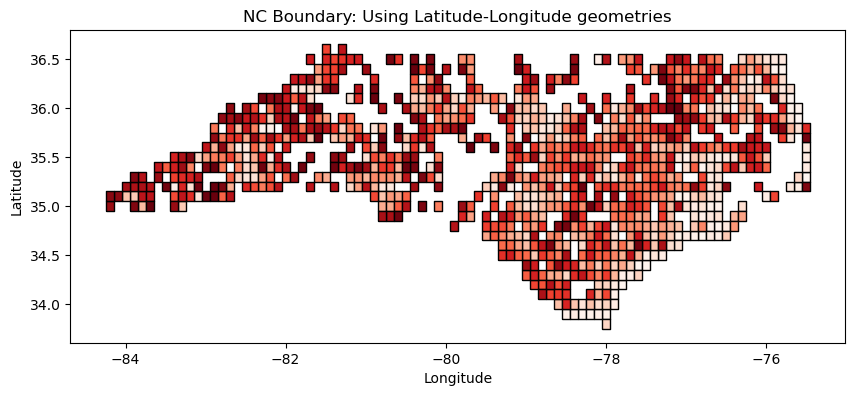

In [110]:
visualize_NC = lat_long_df[(lat_long_df['state'] == 'NC') & (lat_long_df['longitude'] < 174.0) & (lat_long_df['longitude'] < 174.0) & (lat_long_df['latitude'] < 40.0)]

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NC Boundary: Using Latitude-Longitude geometries')

plt.show()

Average Area: 36.86452240476271 square kilometers


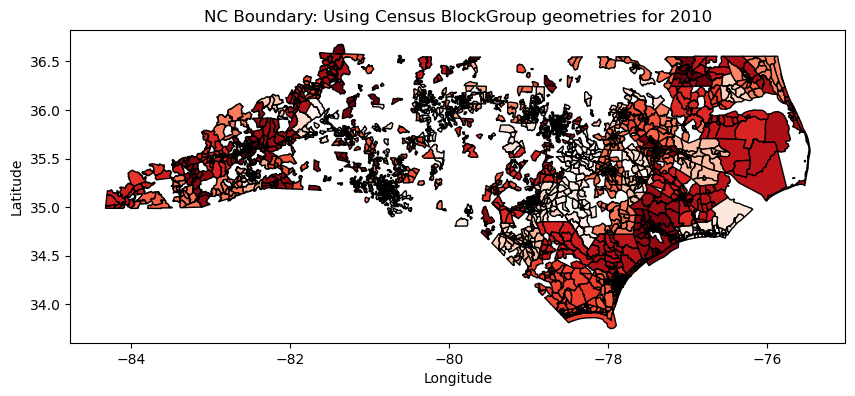

In [125]:
visualize_NC = BG_df[(BG_df['state'] == 'NC') & (BG_df['year'] == 2010)]
# Find the centroid for each geometry
centroids = visualize_NC.geometry.centroid

# Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
visualize_NC = visualize_NC[centroids.y < 37]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NC Boundary: Using Census BlockGroup geometries for 2010')

plt.show()

Average Area: 261.2864793164011 square kilometers


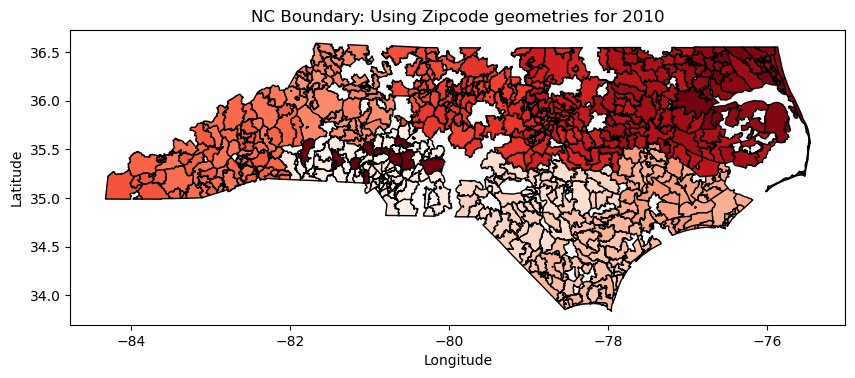

In [126]:
visualize_NC = zipcode_df[(zipcode_df['state'] == 'NC') & (zipcode_df['year'] == 2010)]

centroids = visualize_NC.geometry.centroid

# Filter the rows where the y-coordinate (latitude) of the centroid is greater than 42
visualize_NC = visualize_NC[centroids.y < 37]
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(visualize_NC, geometry='geometry')

# Set the current CRS to WGS 84 (assuming your data is in latitude and longitude)
gdf.crs = "EPSG:4326"

# Project the GeoDataFrame to a suitable CRS (using Web Mercator here for demonstration)
gdf_projected = gdf.to_crs(epsg=3857)

# Compute the average area in square meters
average_area_m2 = gdf_projected.geometry.area.mean()
# Convert the area from square meters to square kilometers
average_area_km2 = average_area_m2 / 1e6
print(f"Average Area: {average_area_km2} square kilometers")

# Plot using the 'viridis' colormap
gdf.plot(edgecolor="black", cmap='Reds', figsize=(10, 10))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('NC Boundary: Using Zipcode geometries for 2010')

plt.show()